In this exercise you will train and analyze a **Convolutional Neural Network (CNN)**.  
The purpose is not to achieve state-of-the-art results, but to explore how three fundamental CNN parameters –  
**kernel size, stride, and padding** – affect the network’s behavior.

You will focus on:

- The shape of feature maps (tensor dimensions after each layer).  
- The number of trainable parameters in each layer and the **total parameters** in the model.  
- Training and validation **accuracy and loss curves** across epochs.  
- Final test performance for different CNN configurations.  

To keep training efficient, we will use a **reduced version of CIFAR-10** containing only 3 classes:  
**airplane, automobile, and bird**. With this simplified dataset, the networks converge in ~30 epochs while still highlighting important architectural differences.

At the end, we compare **five CNN configurations**:

1. Baseline: kernel=3, stride=1, padding="same"  
2. Stride change: kernel=3, stride=2, padding="same"  
3. Larger kernel: kernel=5, stride=1, padding="same"  
4. No padding: kernel=3, stride=1, padding="valid"  
5. Large kernel + stride: kernel=5, stride=2, padding="same"  


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

SEED = 42
tf.keras.utils.set_random_seed(SEED)

In [ ]:
# =========================================================
# Task 1: Load CIFAR-10, keep only 3 classes, and Normalize (dividing by 255)
# =========================================================
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Keep only classes 0,1,2 (airplane, automobile, bird)
keep_classes = [0,1,2]
train_mask = np.isin(y_train.flatten(), keep_classes)
test_mask  = np.isin(y_test.flatten(), keep_classes)

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test   = x_test[test_mask],  y_test[test_mask]

# Normalize
x_train, x_test = ???

# Relabel to 0..num_classes-1
class_map = {c:i for i,c in enumerate(keep_classes)}
y_train = np.vectorize(class_map.get)(y_train)
y_test  = np.vectorize(class_map.get)(y_test)

# Validation split
x_val, y_val = x_train[:3000], y_train[:3000]
x_train, y_train = x_train[3000:], y_train[3000:]

class_names = ['airplane','automobile','bird']

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)
print("Classes:", class_names)


# =========================================================
# Progress Bar Callback (Do not Change)
# =========================================================
class ProgressBarCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        bar_length = 30  # length of bar
        progress = int((epoch+1) / self.total_epochs * bar_length)
        bar = "█" * progress + "-" * (bar_length - progress)
        acc = logs.get("accuracy", 0)
        val_acc = logs.get("val_accuracy", 0)
        print(f"\rEpoch {epoch+1}/{self.total_epochs} |{bar}| "
              f"acc={acc:.3f}, val_acc={val_acc:.3f}", end="")
        if epoch+1 == self.total_epochs:
            print()  # newline

Train: (12000, 32, 32, 3) Val: (3000, 32, 32, 3) Test: (3000, 32, 32, 3)
Classes: ['airplane', 'automobile', 'bird']


In [ ]:
# =========================================================
# Task 2: Build configurable CNN

# Write a function `make_cnn` that builds a small Convolutional Neural Network
# for the CIFAR-10 dataset (using only 3 classes). The function should:
# Accept `kernel_size`, `stride`, and `padding` as arguments, so we can easily experiment with different CNN configurations.
# Include the following layers:
# 1. An **input layer** for 32×32 RGB images.
# 2. A **Conv2D layer** with 32 filters, followed by a **MaxPooling2D** layer.
# 3. A **Conv2D layer** with 64 filters, followed by another **MaxPooling2D** layer.
# 4. A **Flatten** layer to convert feature maps into a vector.
# 5. A **Dense layer** with 64 units and ReLU activation.
# 6. An **output Dense layer** with `num_classes` units (logits, no activation).
# =========================================================


def make_cnn(kernel_size=3, stride=1, padding="same", num_classes=3):
    model = keras.Sequential([
        layers.Input(shape=(32,32,3)),

        ???





        layers.Dense(num_classes, name="logits")
    ], name=f"CNN_k{kernel_size}_s{stride}_p{padding}")
    return model

In [ ]:
# =========================================================
# Task 3: Train and evaluate CNN (define 30 epochs, batch size of 128)
# =========================================================
def train_and_report(kernel_size, stride, padding, epochs=???):
    model = make_cnn(kernel_size, stride, padding, num_classes=len(class_names))

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    print(f"\nTraining CNN: k={kernel_size}, s={stride}, p={padding}")

    hist = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs, batch_size=???, verbose=0,
        callbacks=[ProgressBarCallback(epochs)]
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.3f} | Params: {model.count_params():,}")

    # Plot accuracy and loss curves
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["accuracy"], label="train acc")
    plt.plot(hist.history["val_accuracy"], label="val acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history["loss"], label="train loss")
    plt.plot(hist.history["val_loss"], label="val loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

    # Parameters and tensor shapes
    params = []
    total_params = 0
    for layer in model.layers:
        p = layer.count_params()
        if p > 0:
            try:
                shape = layer.output.shape
            except:
                shape = "N/A"
            params.append([layer.name, layer.__class__.__name__, p, shape])
            total_params += p

    df = pd.DataFrame(params, columns=["Layer","Type","Params","Output shape"])
    print(df)
    print(f"TOTAL PARAMETERS: {total_params:,}")

    # Plot parameters per layer including total
    plt.figure(figsize=(8,4))
    sns.barplot(x="Layer", y="Params", data=df, palette="mako")
    plt.xticks(rotation=45)
    plt.title("Parameters per layer")
    plt.show()

    return test_acc, model.count_params(), df


Training CNN: k=3, s=1, p=same
Epoch 30/30 |██████████████████████████████| acc=0.984, val_acc=0.889
Test Accuracy: 0.892 | Params: 281,795


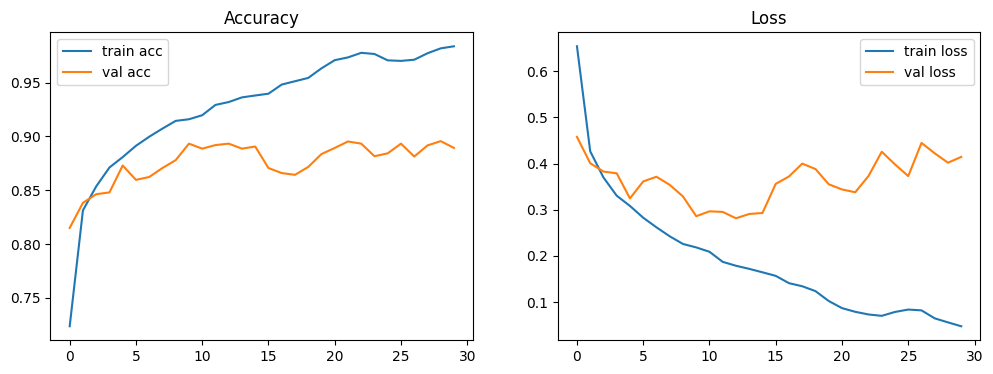

    Layer    Type  Params        Output shape
0   conv1  Conv2D     896  (None, 32, 32, 32)
1   conv2  Conv2D   18496  (None, 16, 16, 64)
2  dense1   Dense  262208          (None, 64)
3  logits   Dense     195           (None, 3)
TOTAL PARAMETERS: 281,795


/tmp/ipython-input-824329680.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Layer", y="Params", data=df, palette="mako")


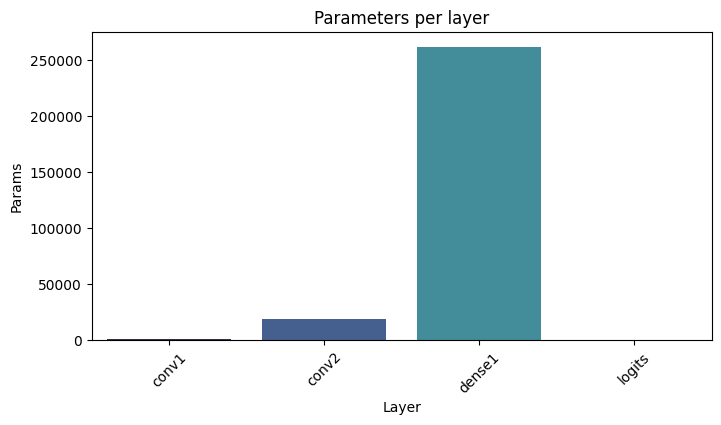


Training CNN: k=3, s=2, p=same
Epoch 30/30 |██████████████████████████████| acc=0.943, val_acc=0.875
Test Accuracy: 0.865 | Params: 36,035


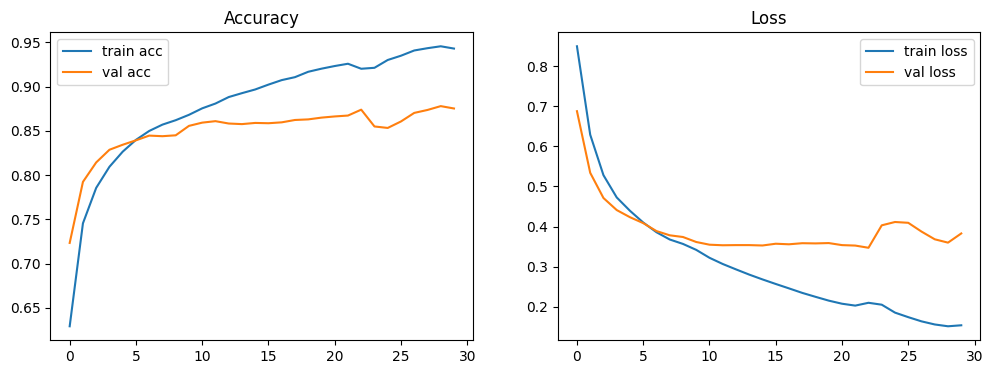

    Layer    Type  Params        Output shape
0   conv1  Conv2D     896  (None, 16, 16, 32)
1   conv2  Conv2D   18496    (None, 4, 4, 64)
2  dense1   Dense   16448          (None, 64)
3  logits   Dense     195           (None, 3)
TOTAL PARAMETERS: 36,035


/tmp/ipython-input-824329680.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Layer", y="Params", data=df, palette="mako")


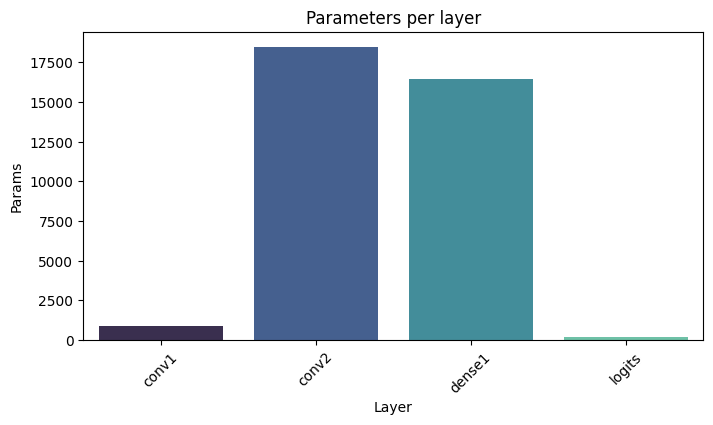


Training CNN: k=5, s=1, p=same
Epoch 30/30 |██████████████████████████████| acc=0.995, val_acc=0.885
Test Accuracy: 0.885 | Params: 316,099


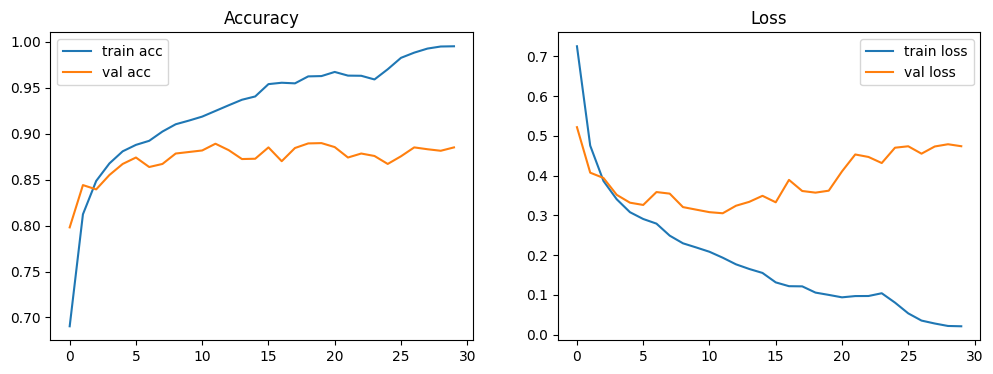

    Layer    Type  Params        Output shape
0   conv1  Conv2D    2432  (None, 32, 32, 32)
1   conv2  Conv2D   51264  (None, 16, 16, 64)
2  dense1   Dense  262208          (None, 64)
3  logits   Dense     195           (None, 3)
TOTAL PARAMETERS: 316,099


/tmp/ipython-input-824329680.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Layer", y="Params", data=df, palette="mako")


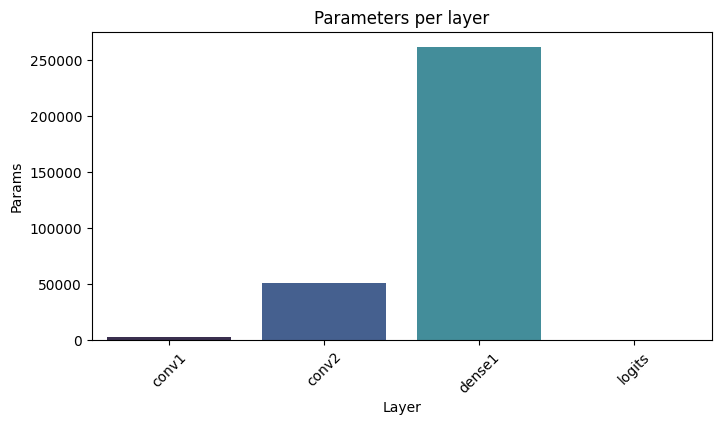


Training CNN: k=3, s=1, p=valid
Epoch 30/30 |██████████████████████████████| acc=0.965, val_acc=0.878
Test Accuracy: 0.876 | Params: 167,107


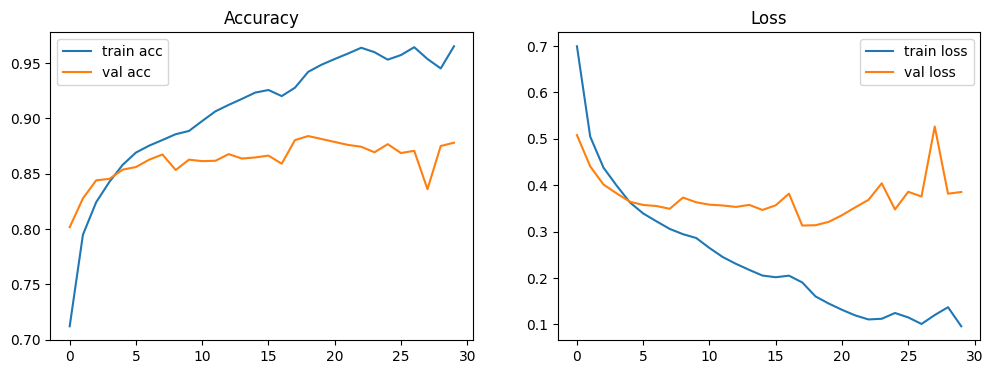

    Layer    Type  Params        Output shape
0   conv1  Conv2D     896  (None, 30, 30, 32)
1   conv2  Conv2D   18496  (None, 13, 13, 64)
2  dense1   Dense  147520          (None, 64)
3  logits   Dense     195           (None, 3)
TOTAL PARAMETERS: 167,107


/tmp/ipython-input-824329680.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Layer", y="Params", data=df, palette="mako")


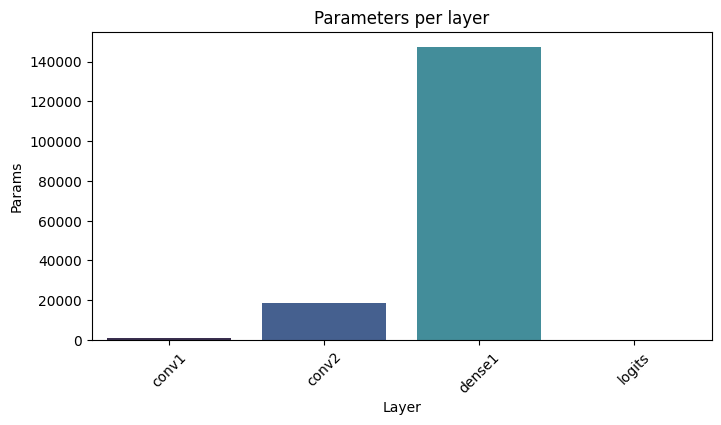


Training CNN: k=5, s=2, p=same
Epoch 30/30 |██████████████████████████████| acc=0.982, val_acc=0.886
Test Accuracy: 0.870 | Params: 70,339


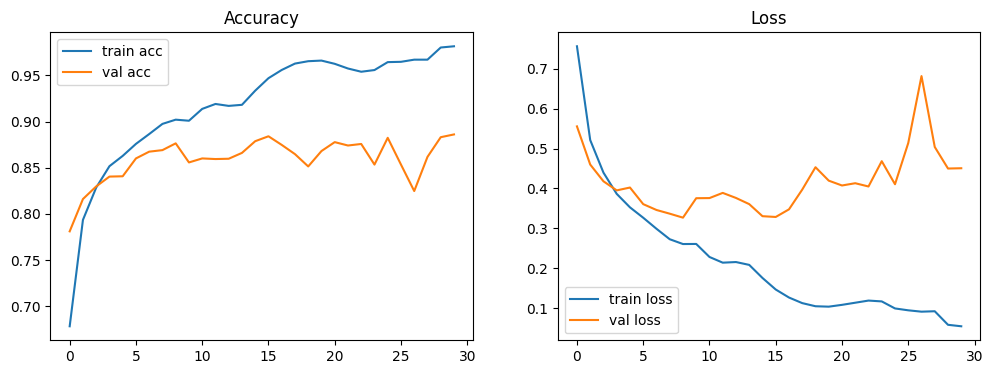

    Layer    Type  Params        Output shape
0   conv1  Conv2D    2432  (None, 16, 16, 32)
1   conv2  Conv2D   51264    (None, 4, 4, 64)
2  dense1   Dense   16448          (None, 64)
3  logits   Dense     195           (None, 3)
TOTAL PARAMETERS: 70,339


/tmp/ipython-input-824329680.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Layer", y="Params", data=df, palette="mako")


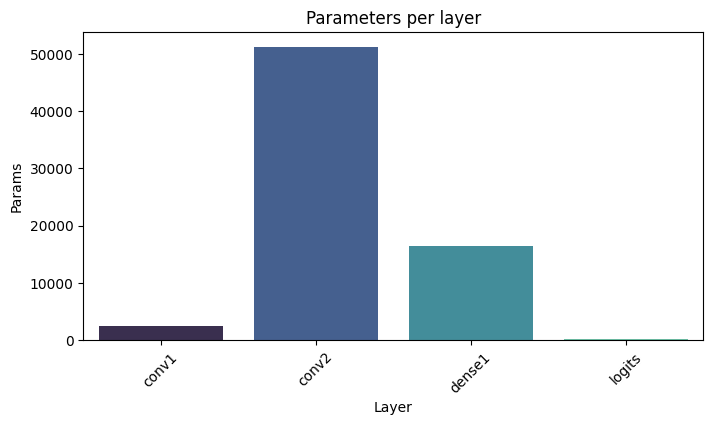

In [ ]:
# =========================================================
# Task 4: Run 5 configurations, you can suggest other configurations.
# =========================================================
results = []
tables = {}

configs = [
    (3,1,"same"),   # baseline
    (3,2,"same"),   # stride=2
    (5,1,"same"),   # larger kernel
    (3,1,"valid"),  # no padding
    (5,2,"same"),   # large kernel + stride=2
]

for (k,s,p) in configs:
    acc, params, df = train_and_report(k,s,p, epochs=30)
    results.append((f"k{k}_s{s}_{p}", acc, params))
    tables[f"k{k}_s{s}_{p}"] = df



=== Final Comparison ===
        Config  Accuracy  Total Params
0   k3_s1_same  0.891667        281795
1   k3_s2_same  0.865333         36035
2   k5_s1_same  0.885333        316099
3  k3_s1_valid  0.876000        167107
4   k5_s2_same  0.870000         70339


/tmp/ipython-input-347518311.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Config", y="Accuracy", data=df_sorted_acc, palette="Blues_d")


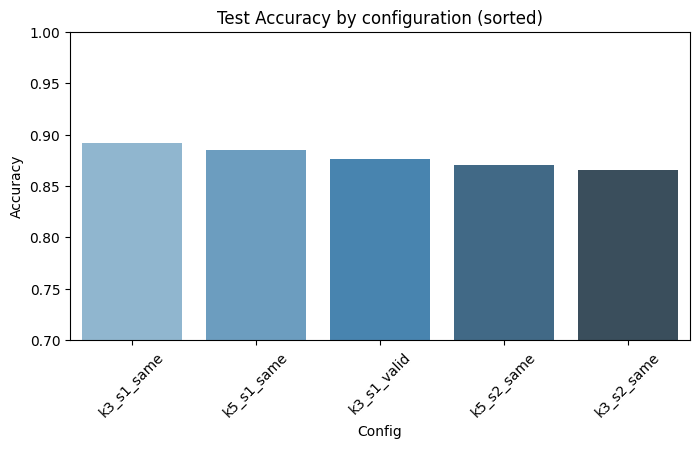

/tmp/ipython-input-347518311.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Config", y="Total Params", data=df_sorted_params, palette="Greens_d")


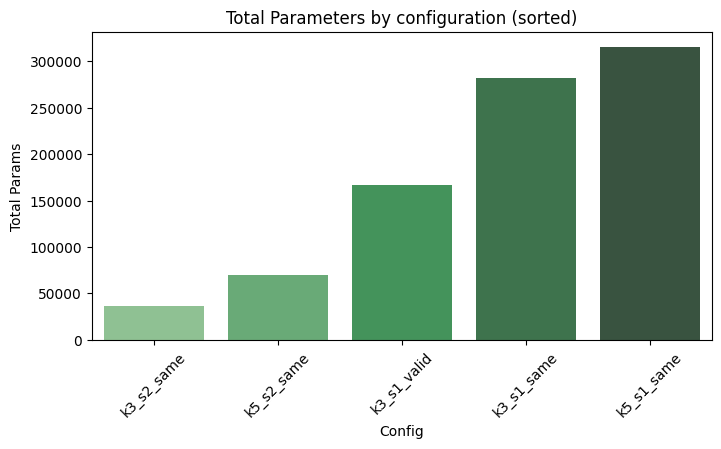

In [ ]:
# =========================================================
# Task 5: Compare results
# =========================================================
df_res = pd.DataFrame(results, columns=["Config","Accuracy","Total Params"])
print("\n=== Final Comparison ===")
print(df_res)

# Accuracy comparison (y-axis fixed from 0.7 to 1.0)
df_sorted_acc = df_res.sort_values("Accuracy", ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x="Config", y="Accuracy", data=df_sorted_acc, palette="Blues_d")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.title("Test Accuracy by configuration (sorted)")
plt.show()

# Parameter comparison (sorted by params)
df_sorted_params = df_res.sort_values("Total Params", ascending=True)
plt.figure(figsize=(8,4))
sns.barplot(x="Config", y="Total Params", data=df_sorted_params, palette="Greens_d")
plt.xticks(rotation=45)
plt.title("Total Parameters by configuration (sorted)")
plt.show()